## Part A. Document Clustering

### Question 1 [EM for Document Clustering, 40 Marks]

#### I. Derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering, show your work in your submitted PDF report. In particular, include all model parameters that should be learnt and the exact expression (using the same math convention that we saw in the Module 4) that should be used to update these parameters during the learning process (ie., E step, M step and assignments).

**Ans.** As per the problem we would like to partition a collection of documents {$d_1$, $d_2$, ..., $d_N$} into K clusters. Since this is an unsupervised learning problem the document clusters are not given to us.  
Each document $d_n$ is made up of some text and we assume that the words in the documents come from a dictionary denoted by $\mathcal{A}$.  

**Generative Model** - The following hypothetical generative story is for generating the collection of our documents:  
For each document $d_n$ 
1. Toss a K-face dice(with parameter $\pmb{\varphi}$) to chose the face (i.e. the cluster) k to which $d_n$ belongs to
2. For eachword placeholder in the document $d_n$ generate the word by tossing the dice (with parameter $\mu_k$) corresponding to the face k  

**Model Parameters** - The parameters of the model are:
1. The cluster proportion $\mathcal{A}$ - A probability vector of size K where, $\sum_{k=1}^K \varphi_k = 1$
2. The word proportion $\mu_k$ which corresponds to the kth face of the dice where, $\sum_{w \in \mathcal{A}} \mu_{k,w} = 1$; we have K such word proportion vectors each corresponding to a different cluster.

The probability of generating a pair of a document and its cluster (k,d) is:
$$
\begin{eqnarray} 
p(k,d) = p(k) p(d|k) &=& \varphi_k \prod_{w \in d} \mu_{k,w} \\ 
&=&\varphi_k \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w,d)} 
\end{eqnarray}
$$  
where c(w,d) is simply the number of accurences of the word w in document d.

**The Likelihood**

In [21]:
# importing required libraries
library(tm)
library(SnowballC)

Warning message:
"package 'SnowballC' was built under R version 3.6.3"

In [38]:
eps=1e-10
  
# reading the data
read.data <- function(file.name='./assessments_datasets/Task3A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id = 1:length(docs), text = unlist(lapply(docs, function(x) x[2])))
  
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}


In [4]:
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [5]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

In [6]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
# soft-em
E.soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

In [7]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
# hard-em
E.hard <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # generating a boolean vector 
    idx = (gamma[n,] == gamma[n, which.max(gamma[n,])])
    # replacing 1 where max is found
    gamma[n, idx] = 1
    # replacing 0 where max is not found
    gamma[n, !idx] = 0
  }

  return (gamma)
}

In [8]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  #......
  #
  # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
  # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
  # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
  # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
  # results in the uniform distribution after normalisation.  
  for (k in 1:K) {
      
      model$rho[k] = sum(gamma[,k])/N
      
      model$mu[k,] = colSums(gamma[,k] * t(counts))    
  }
    model$mu = model$mu + eps   # adding and eps small value
    model$mu = model$mu/rowSums(model$mu)  #word proportion

  # Return the result
  return (model)
}

In [9]:
##--- EM for Document Clustering --------------------------------------------
# additional parameter hard to specifiy which em algorithm to use
EM <- function(counts, K=4, max.epoch=10, seed=123456, hard = FALSE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step for hard
    if (hard){
        gamma <- E.hard(gamma, model, counts)
    } 
    # E step for soft
    else {
        gamma <- E.soft(gamma, model, counts)
    }
    # M Step
    model <- M.step(gamma, model, counts)

  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

In [10]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

In [11]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

In [39]:
# reading the data
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6) 

In [40]:
# implementing the Soft-EM algorithm
soft_res <- EM(counts, K=4, max.epoch=5, hard = FALSE)   

# Assigning to clusters
soft_label <- apply(soft_res$gamma, 1, which.max)

[1] 2173212


In [41]:
# implementing the Hard-EM algorithm
hard_res <- EM(counts, K=4, max.epoch=5, hard = TRUE)   

# Assigning to clusters
hard_label <- apply(hard_res$gamma, 1, which.max)

[1] 2180179


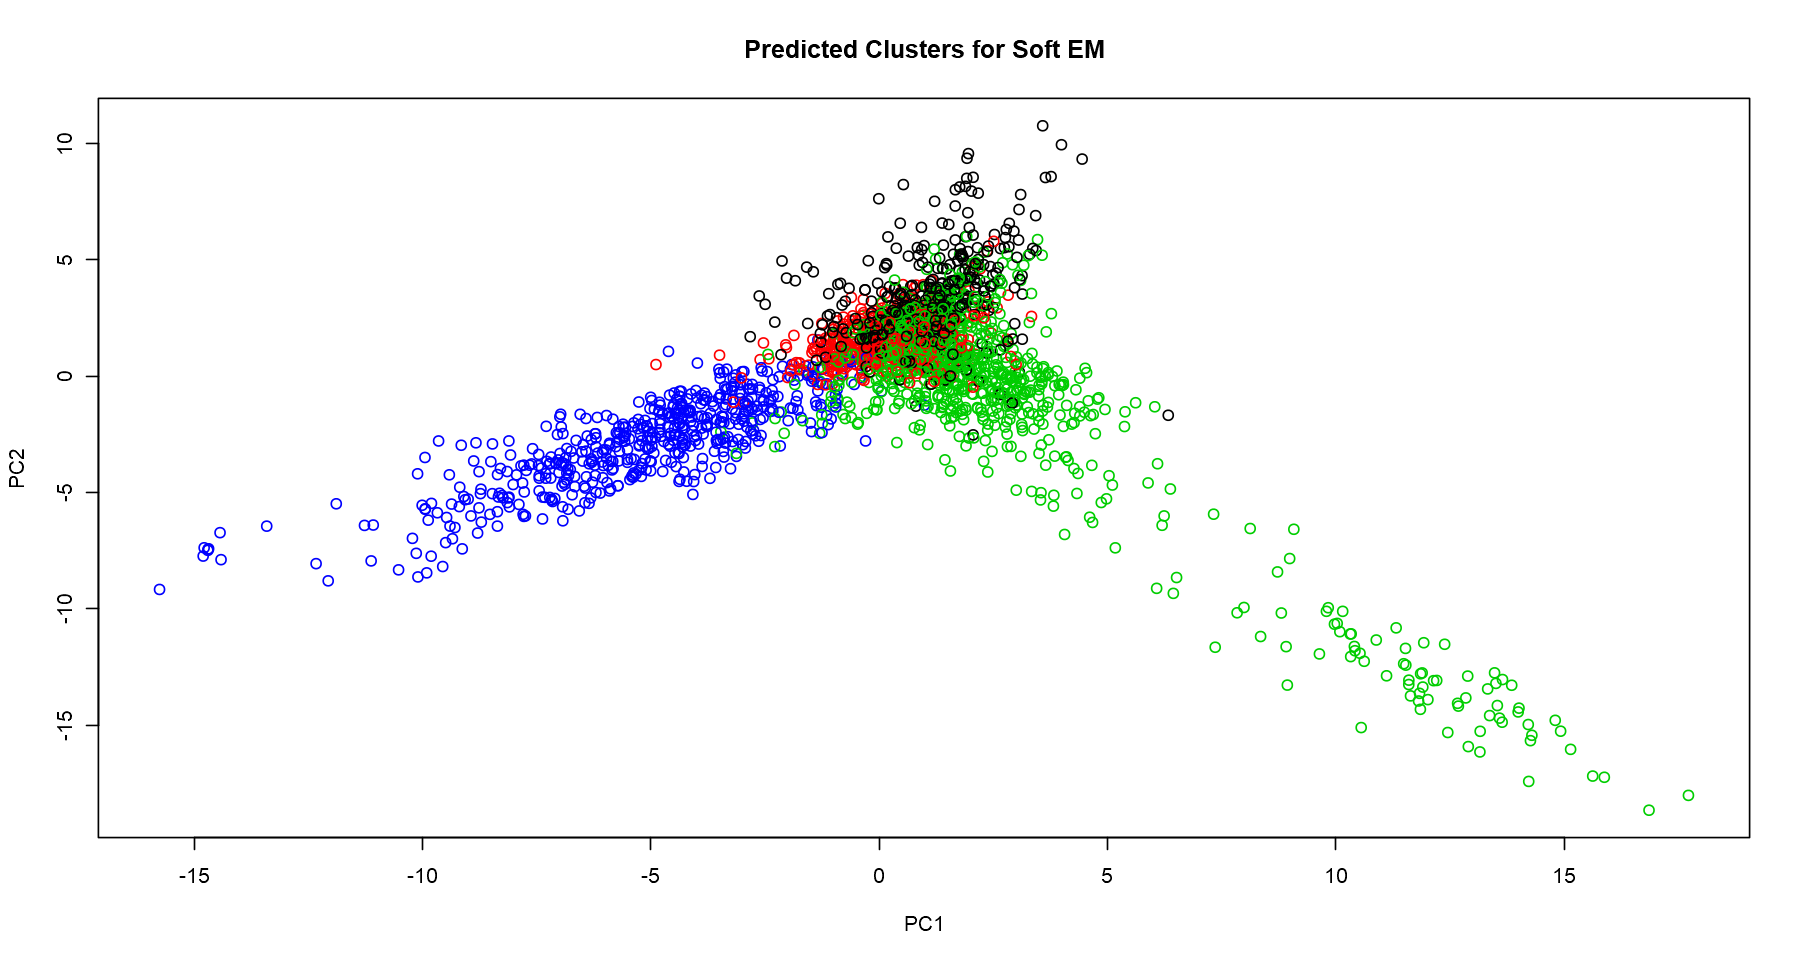

In [46]:
counts <- scale(counts)
options(repr.plot.width=15, repr.plot.height=8)
# plotting the soft EM Clusters
cluster.viz(t(scale(counts)), soft_label, 'Predicted Clusters for Soft EM')

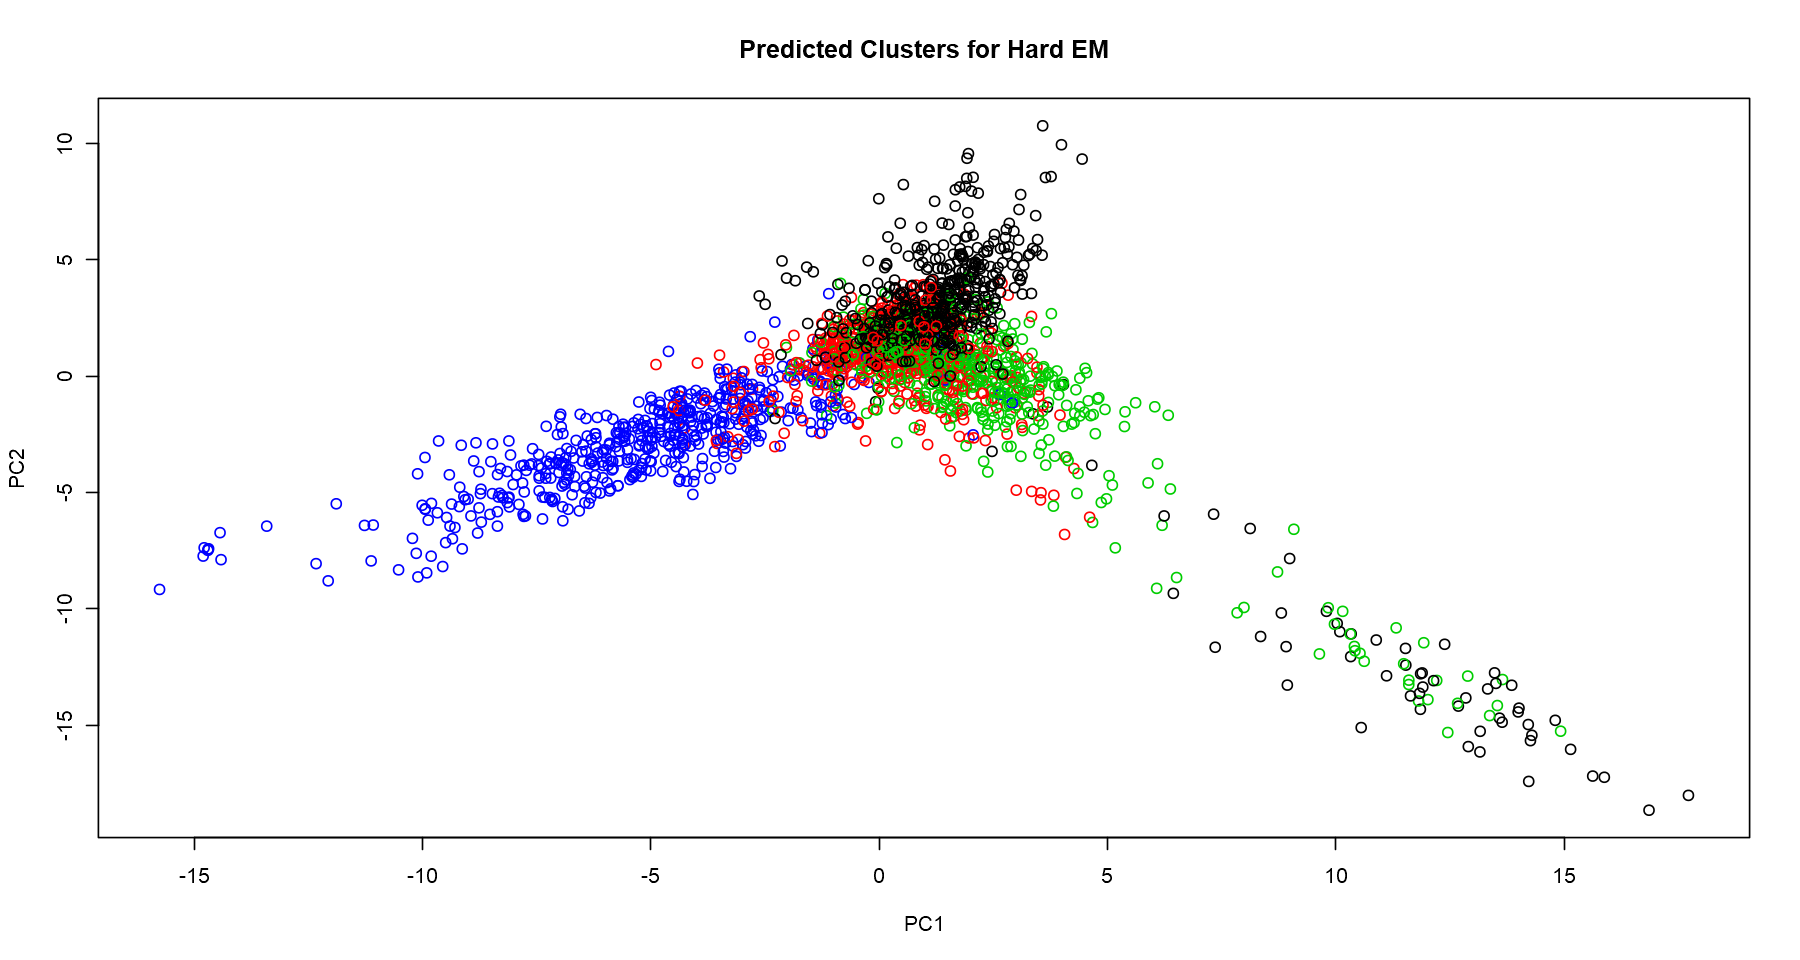

In [45]:
# plotting the hard EM Clusters
cluster.viz(t(counts), hard_label, 'Predicted Clusters for Hard EM')